## Binary Classification with a Bank Churn Dataset
- to predict whether a customer continues with their account or closes it (e.g., churns)
- churn: 가입자 이탈률

---

- id
- CustomerId: A unique identifier for each customer
- Surname: The customer's surname or last name 
- CreditScore: A numerial value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance (잔액)
- Num Of Products: The number of bank products the customer uses (e.g., saving account, credit card)
- HasCrCard: Whether the customer has a credit card (1=yes, 0=no)
- isActiveMember: Whether the customer is an active member(1=yes, 0=no)
- EstimatedSalary: The estimated salary of the customer
- `Exited`: Whether the customer has churned (1=yes, 0=no)

---

- Evaluation: area under ROC curve between the predicted probability and the observed target

---

https://www.kaggle.com/code/getanmolgupta01/bank-churn-eda-catboost-lgbm-xgboost

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# train data
df = pd.read_csv('bank_train.csv')
print(df.shape)
df.head(3)

(165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [3]:
# Drop unmeaningful columns: 단순 식별자 drop
cols = ['id', 'CustomerId', 'Surname']
df.drop(cols, axis=1, inplace=True)

# Check if there's any duplicated Recrods
df = df.drop_duplicates()

In [4]:
def categorical_plot(df, col, target_col):
    plt.figure(figsize=(10, 3))
    
    value_counts = df[col].value_counts().sort_index()
    
    # pie chart
    plt.subplot(1, 2, 1)
    colors = sns.color_palette('Set2', len(value_counts))
    plt.title(f'Distribution by {col}')
    plt.pie(value_counts.values, labels=value_counts.index, colors=colors,
           autopct='%.2f%%', startangle=90, pctdistance=0.75, textprops={'size':8})
    
    # bar plot : Attrition Rate by col
    plt.subplot(1, 2, 2)
    
    value_1 = value_counts
    value_2 = df.loc[df[target_col]==1, col].value_counts().sort_index()
    rate = np.floor((value_2/value_1)*100).values
    
    plt.title(f'Attrition by {col}')
    sns.barplot(x=value_2.index, y=value_2.values, palette='Set2')
    for idx, value in enumerate(value_2.values):
        s = str(value) + '(' + str(int(rate[idx])) + '%)'
        plt.text(idx, value, s, ha='center', size=8)
        

def numerical_plot(df, col, target_col):
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 2, 1)
    plt.title(f'Distribution by {col}')
    sns.histplot(x=col, hue=df[target_col], data=df, kde=True, palette='Set2')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Distribution by {col} & {target_col}')
    sns.violinplot(x=df[target_col], y=col, data=df, palette='Set2')

## No_Balance, Almost_Exited
**고객 이탈을 어떻게 정의할 것인가** → 더이상 서비스를 이용하지 않는 고객

In [5]:
df['Exited'].value_counts()

0    130002
1     34909
Name: Exited, dtype: int64

In [6]:
# 계좌 잔액이 0원인지 여부: 0원(1), 아니면(0)
df.loc[df['Balance']==0, 'No_Balance'] = 1
df.loc[df['Balance']!=0, 'No_Balance'] = 0

df.groupby('No_Balance')['Exited'].value_counts()

No_Balance  Exited
0.0         0         54913
            1         20419
1.0         0         75089
            1         14490
Name: Exited, dtype: int64

- 계좌 잔액이 0원인 사람이 거의 9만명으로 절반 이상을 차지 (?) → 일단 진행..

In [7]:
df[df['No_Balance']==1]['Tenure'].value_counts().sort_index()

0      2461
1      8709
2     10080
3      8896
4      9672
5      9325
6      8628
7     10040
8      9612
9      9093
10     3063
Name: Tenure, dtype: int64

- 계좌 잔액이 0 인데 아직 은행을 이용한지 1년이 되지 않았다면 이탈 X
- 1년 이상 은행을 이용했다면 이탈 O

In [8]:
df['Sleepy'] = 0 # 휴면 상태
df.loc[(df['No_Balance']==1) & (df['Tenure']>0), 'Sleepy'] = 1
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,No_Balance,Sleepy
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,1
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,1
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,1
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.0,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1.0,1
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0,1
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.0,1
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0,0


In [9]:
# 카이제곱 검정
from scipy.stats import chi2_contingency, contingency

table = pd.crosstab(df['Sleepy'], df['Exited'])
chi2_contingency(table)

Chi2ContingencyResult(statistic=2870.695920949378, pvalue=0.0, dof=1, expected_freq=array([[61325.47608104, 16467.52391896],
       [68676.52391896, 18441.47608104]]))

- 궁금해져서 살펴본 Sleepy ~= Exited 를 만드는 n?

In [10]:
for n in range(0, 10):
    almost_array = (df['No_Balance']==1) & (df['Tenure']>n)
    exited_array = np.array(df.Exited)
    print((almost_array==exited_array).sum())

70892
76553
83713
89409
95681
101846
107864
115092
121812
127929


In [11]:
len(exited_array)

164911

In [12]:
df['Sleepy'] = 0
df.loc[(df['No_Balance']==1) & (df['Tenure']>9), 'Sleepy'] = 1

table = pd.crosstab(df['Sleepy'], df['Exited'])
chi2_contingency(table)

Chi2ContingencyResult(statistic=46.59639282982774, pvalue=8.722065873072011e-12, dof=1, expected_freq=array([[127587.38771822,  34260.61228178],
       [  2414.61228178,    648.38771822]]))

- 둘 다 유의하긴 하지만, 계좌 잔액 0 , Tenure 1년 이상 (1) 로 잡았을 때 상관 분석 결과가 더 유의하므로
- 다시 Sleepy를 계좌 잔액 0, Tenure 1년 이상이면 1이 되도록 변경

In [13]:
df['Sleepy'] = 0
df.loc[(df['No_Balance']==1) & (df['Tenure']>0), 'Sleepy'] = 1

## **Extreme_Tenure**

In [14]:
df['Extreme_Tenure'] = 0
df.loc[(df['Tenure']==0) | (df['Tenure']==10), 'Extreme_Tenure'] = 1

In [15]:
table = pd.crosstab(df['Extreme_Tenure'], df['Exited'])
print(table)
chi2_contingency(table)

Exited               0      1
Extreme_Tenure               
0               121622  32379
1                 8380   2530


Chi2ContingencyResult(statistic=28.475578979369423, pvalue=9.488781844769548e-08, dof=1, expected_freq=array([[121401.47110866,  32599.52889134],
       [  8600.52889134,   2309.47110866]]))

## **VIP**
- 여러 상품 보유 + 장기 이용 고객 > 이탈률 낮지 않을까?
- NumOfProducts 2 이상 (3, 4 로만 하면 너무 극단적인 분포)
- Tenure 5년 이상

In [16]:
df['VIP'] = 0
df.loc[(df['NumOfProducts']>1) & (df['Tenure']>=5), 'VIP'] = 1

In [17]:
table = pd.crosstab(df['VIP'], df['Exited'])
chi2_contingency(table)

Chi2ContingencyResult(statistic=6348.396718716091, pvalue=0.0, dof=1, expected_freq=array([[91659.88045673, 24613.11954327],
       [38342.11954327, 10295.88045673]]))

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,No_Balance,Sleepy,Extreme_Tenure,VIP
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,1,0,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,1,0,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,1,1,1
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.0,0,0,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1.0,1,0,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0,1,0,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.0,1,0,0
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0,0,0,0


In [19]:
df.select_dtypes(include='number').corrwith(df['Exited'])

CreditScore       -0.027541
Age                0.341009
Tenure            -0.019557
Balance            0.129669
NumOfProducts     -0.214598
HasCrCard         -0.022141
IsActiveMember    -0.210254
EstimatedSalary    0.018722
Exited             1.000000
No_Balance        -0.133277
Sleepy            -0.131953
Extreme_Tenure     0.013170
VIP               -0.196220
dtype: float64

In [20]:
# HasCrCard, IsActiveMember, Sleepy 등의 0, 1 값을 가지는 범주형 변수와의 상관계수 어떤 의미?

## **40대 EDA**

In [21]:
labels = ["{0}s".format(i) for i in range(10, 100, 10)]
print(labels)

df['Age_group'] = pd.cut(df['Age'], range(10, 105, 10), right=False, labels=labels) # 0~10 없음
df[:20]

['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,No_Balance,Sleepy,Extreme_Tenure,VIP,Age_group
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,1,0,0,30s
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,1,0,0,30s
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,1,1,1,40s
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.0,0,0,0,30s
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0,1,0,1,30s
5,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1,0.0,0,0,0,30s
6,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0,0.0,0,0,0,30s
7,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0,0.0,0,0,0,30s
8,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0,1.0,1,0,0,40s
9,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0,0.0,0,0,0,40s


In [22]:
df.loc[df['Exited']==1, 'Age_group'].value_counts().sort_index()

10s       34
20s     1930
30s     8796
40s    15072
50s     7424
60s     1518
70s      128
80s        6
90s        1
Name: Age_group, dtype: int64

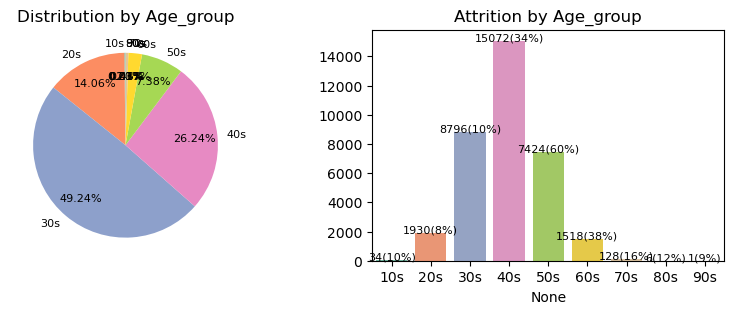

In [23]:
categorical_plot(df, 'Age_group', 'Exited')

- 이탈자 중 40대가 가장 많음
- 연령대 별 이탈 비율로는 50대가 제일 많지만, 여기선 40대를 타깃으로 분석

In [26]:
df_40 = df[df['Age_group'] == '40s']
df_40.drop('Age_group', axis=1, inplace=True)
df_40.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,No_Balance,Sleepy,Extreme_Tenure,VIP
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,1,1,1
8,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0,1.0,1,0,0
9,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0,0.0,0,0,0
11,687,Germany,Male,40.0,3,90432.92,1,1.0,0.0,1676.92,0,0.0,0,0,0
13,681,France,Male,47.0,5,0.00,1,1.0,1.0,72945.68,0,1.0,1,0,0


## 1) Categorical plot

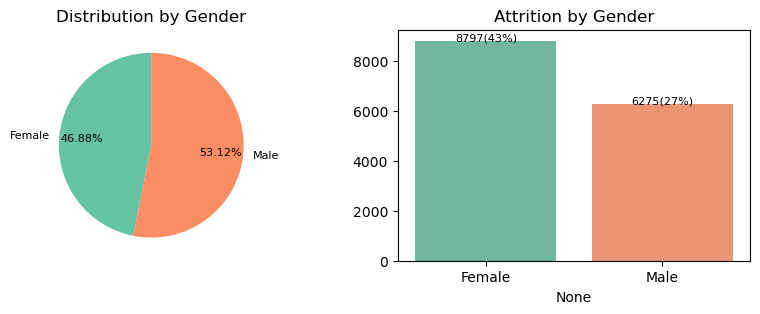

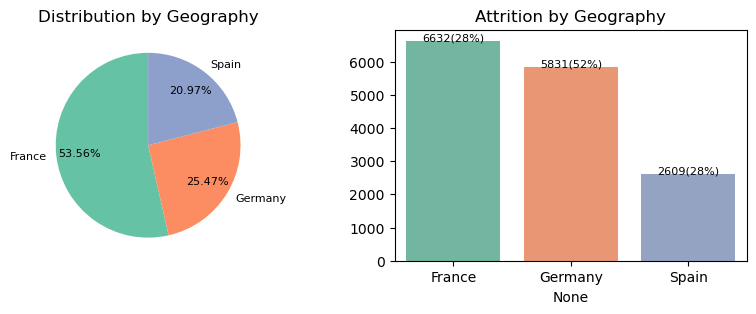

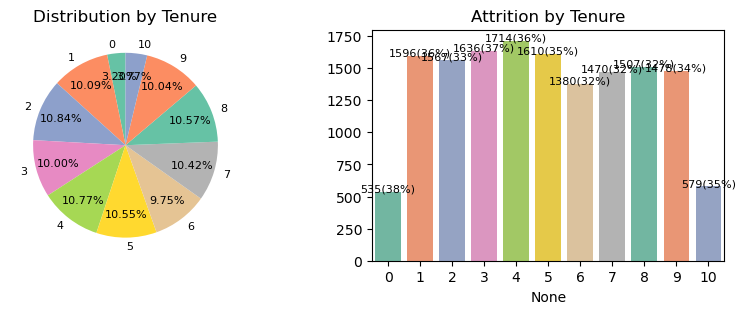

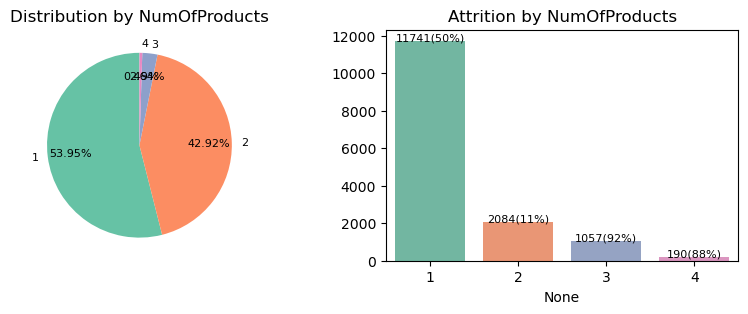

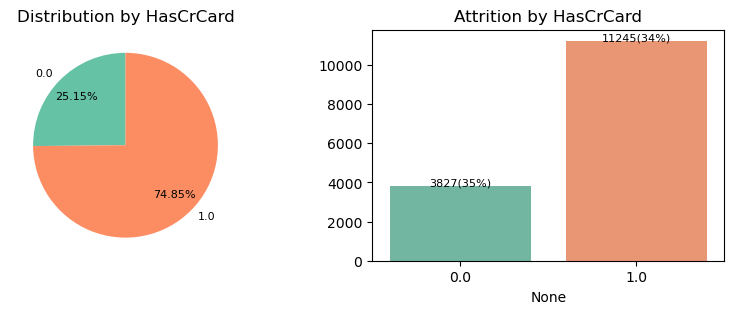

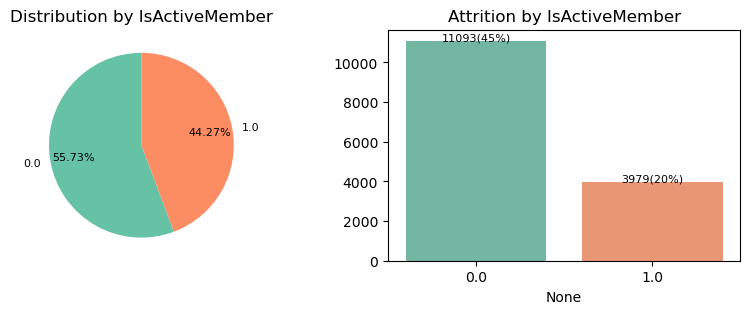

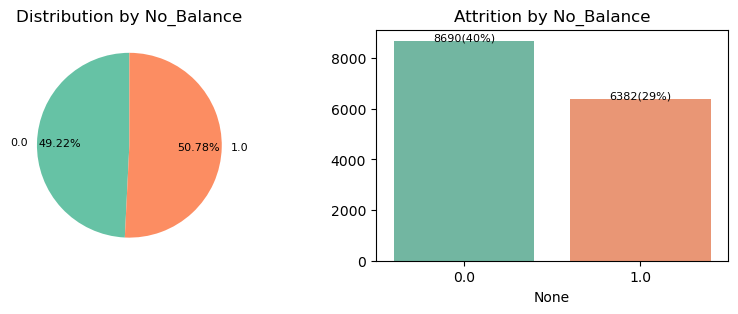

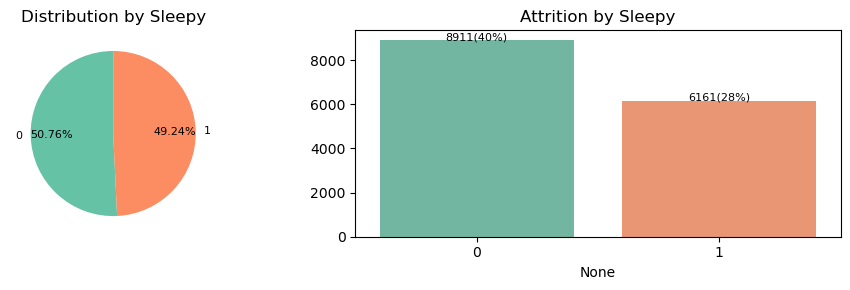

In [28]:
categorical_cols = ['Gender', 'Geography', 'Tenure', 
                    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'No_Balance', 'Sleepy']

for col in categorical_cols:
    categorical_plot(df_40, col, 'Exited')
plt.tight_layout()
plt.show()

- 각 범주 내 비율은 차이가 있지만, 전체적인 경향은 전체 연령 대상의 데이터 세트와 동일함
- 오히려 계좌가 0인 고객 내 이탈률이 더 높음..?
- 휴면 계정(Sleepy=0)인 고객 내 이탈률이 더 높음..?

<Axes: xlabel='Tenure', ylabel='Exited'>

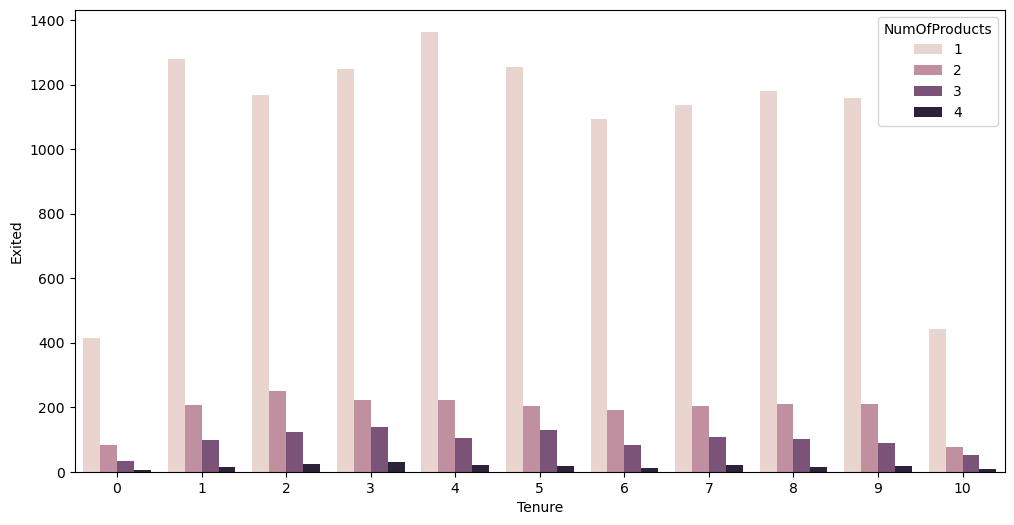

In [29]:
grouped_data = df_40.groupby(['Tenure', 'NumOfProducts'])['Exited'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='Tenure', y='Exited', hue='NumOfProducts')

## **2) Numerical plot**

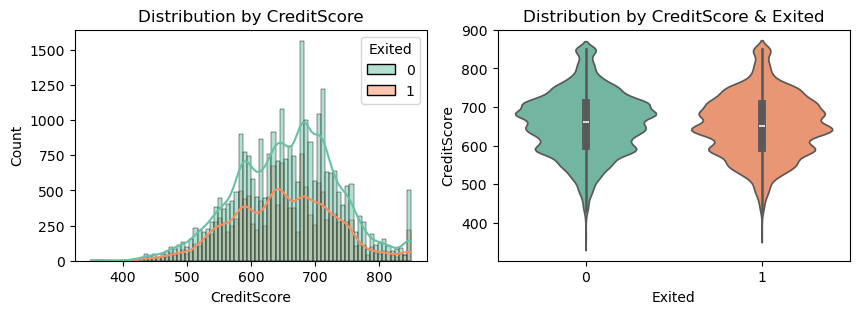

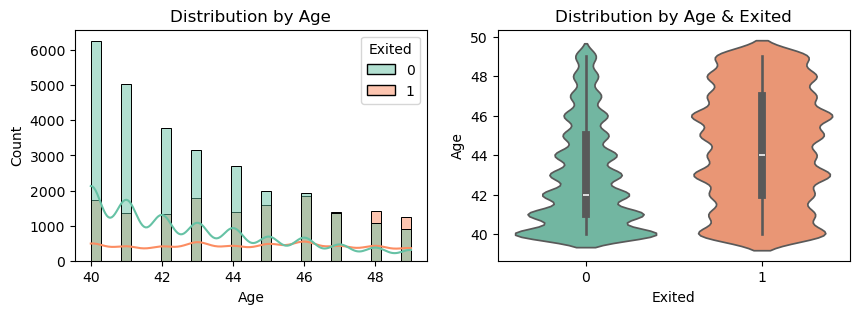

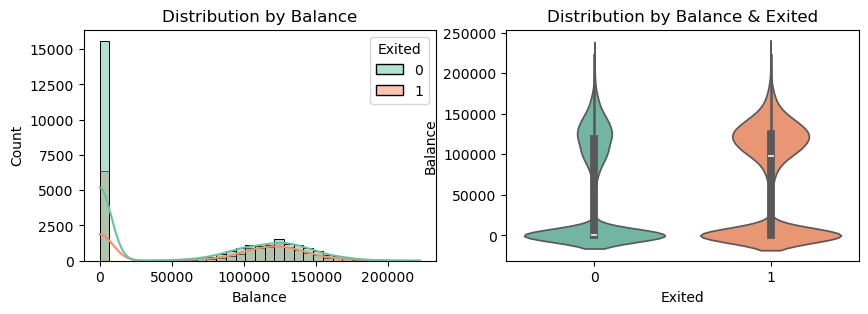

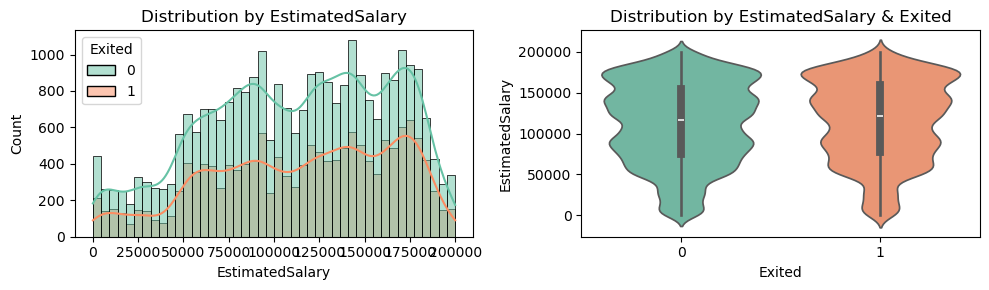

In [30]:
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in numerical_cols:
    numerical_plot(df_40, col, 'Exited')
plt.tight_layout()
plt.show()

- 각 범주 내 비율은 차이가 있지만, 전체적인 경향은 전체 연령 대상의 데이터 세트와 동일함

**Age** | 40대 중반을 넘어가면서부터 급격하게 이탈률이 증가